# Time-series Analysis of weather-data

## 1. Preparing the data

### 1.1 Importing the necessay libraries and modules

In [1]:
#Libraries
import pandas as pd
import numpy as np

#Modules for visualisation and describtion
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import plot_roc_curve, auc, roc_curve
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsmodels.tsa.ar_model import AutoReg

#ML-models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#Params for the display of figures
plt.rcParams['figure.figsize'] = (14,6)
sns.set()

In [2]:
def plot_temp(df, title='Temperature', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset provided by Spiced Academy
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('tg')
    #plt.xlabel('date')
    if ylim:
        plt.ylim(ymin=False)
    plt.show()

### 1.2 Loading the data

In [3]:
df = pd.read_csv('~/Documents/spiced_work/own_code/week7/data/TG_STAID011781 (copy).txt', sep = ',', skiprows=19)

### 1.3 EDA

In [4]:
df.head()

,SOUID,DATE,TG,Q_TG
0,181383,18910101,-107,0
1,181383,18910102,-76,0
2,181383,18910103,-103,0
3,181383,18910104,-13,0
4,181383,18910105,-41,0


In [5]:
#Renaming the columns to get rid of blank spaces in the original data
df = df.rename(columns={' SOUID':'souid','    DATE':'date', '   TG': 'tg',' Q_TG':'q_tg'})

In [6]:
df.tail()

,souid,date,tg,q_tg
47720,123276,20210827,151,0
47721,123276,20210828,152,0
47722,123276,20210829,158,0
47723,123276,20210830,169,0
47724,123276,20210831,166,0


In [7]:
# Checking for missing values
df.isna().sum()

souid    0
date     0
tg       0
q_tg     0
dtype: int64

In [8]:
# Checking the validity of the q_tg column
df['q_tg'].unique()

array([0, 1])

In [9]:
# Dropping unneseccary colums
df = df.drop(['q_tg', 'souid'], axis=1)

### 1.4 Converting the date and plotting the data

In [10]:
type('date')

str

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')

In [12]:
df.head()

,date,tg
0,1891-01-01,-107
1,1891-01-02,-76
2,1891-01-03,-103
3,1891-01-04,-13
4,1891-01-05,-41


In [13]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day

In [14]:
df.sample(n=10)

,date,tg,year,month,day
8876,1915-04-22,65,1915,4,22
32187,1979-02-16,-66,1979,2,16
30793,1975-04-24,80,1975,4,24
34873,1986-06-25,190,1986,6,25
21486,1949-10-30,46,1949,10,30
2922,1899-01-01,4,1899,1,1
8472,1914-03-14,78,1914,3,14
8963,1915-07-18,144,1915,7,18
2172,1896-12-12,23,1896,12,12
18441,1941-06-29,160,1941,6,29


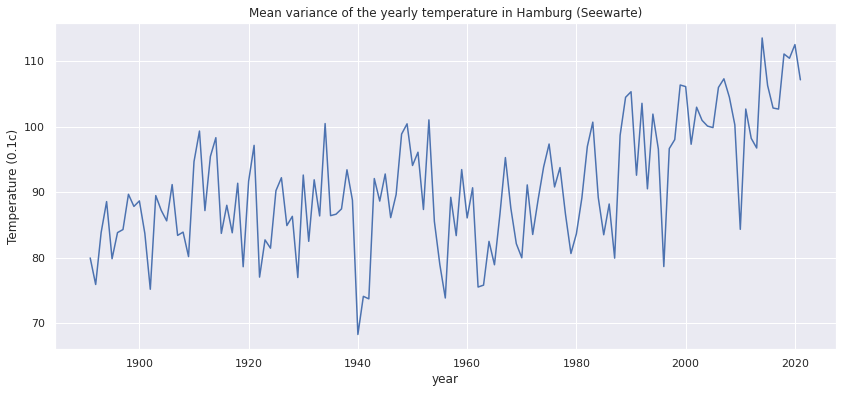

<Figure size 1008x432 with 0 Axes>

In [15]:
df.groupby('year')['tg'].mean().plot()
plt.title("Mean variance of the yearly temperature in Hamburg (Seewarte)")
plt.ylabel('Temperature (0.1c)')
plt.show()
plt.savefig("Mean variance of the yearly temperature in Hamburg (Seewarte).png", transparent=False, bbox_inches='tight')

## 2. Train-Test-Split

In [16]:
#Only the last year of the data will be used as test-data to maximize the training
df_train = df[:-365]
df_test = df[-365:]

## 3. Feature-engeneering and Instatiating a base LR-model

### 3.1 Base LR-model with trend

In [17]:
# Creating a timestep
df_train['timestep'] = list(range(len(df_train)))

<ipython-input-17-3053e4f6cbae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['timestep'] = list(range(len(df_train)))


In [18]:
df_train.tail()

,date,tg,year,month,day,timestep
47355,2020-08-27,159,2020,8,27,47355
47356,2020-08-28,163,2020,8,28,47356
47357,2020-08-29,164,2020,8,29,47357
47358,2020-08-30,167,2020,8,30,47358
47359,2020-08-31,159,2020,8,31,47359


In [20]:
# Defining X and y
X_train = df_train[['timestep']]
y_train = df_train['tg']

# instantiate the linear model
lr = LinearRegression()

# fit the model 
lr.fit(X_train,y_train)

LinearRegression()

#### 3.1.1 Baseline-score

In [21]:
#calculating the R2-score
base_score = np.round(lr.score(X_train,y_train),3)
base_score

0.006

In [22]:
# Computing the overall trend as a variable for the model
df_train['trend'] = lr.predict(X_train)

<ipython-input-22-ecf0f07ef98b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend'] = lr.predict(X_train)


<AxesSubplot:xlabel='year'>

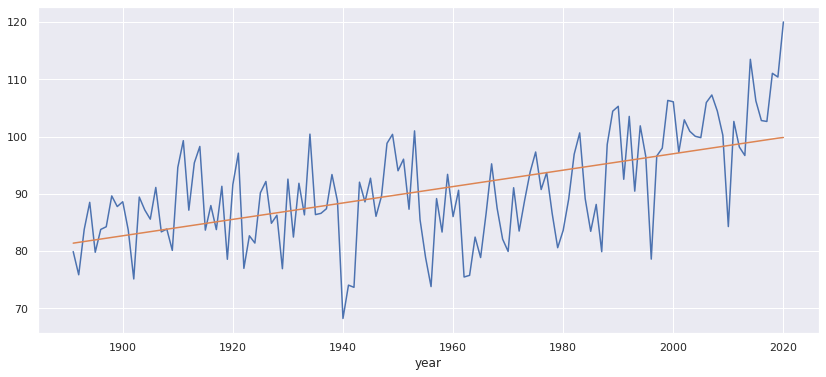

In [23]:
df_train.groupby('year')['tg'].mean().plot()
df_train.groupby('year')['trend'].mean().plot()

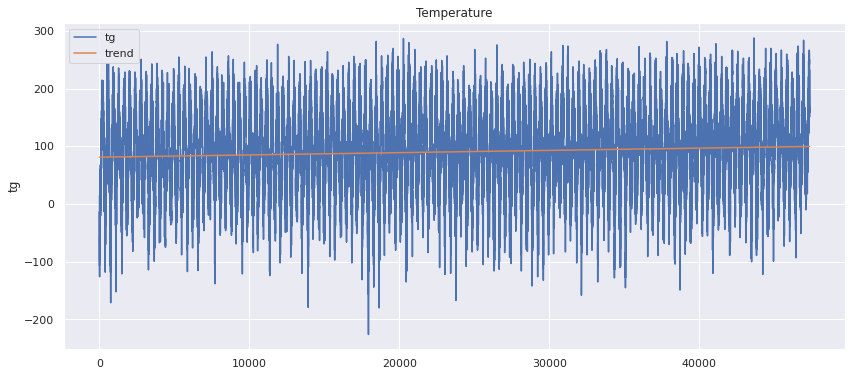

In [24]:
plot_temp(df=df_train[['tg', 'trend']], ylim= False)

### 3.2 OHE-encoding of variables and rerunning the model for seasonal data

In [25]:
# One-Hot-Encoding the months
seasonal_dummies = pd.get_dummies(df_train['month'],prefix='month',drop_first=True)

In [26]:
#Combining with the dummies
df_train = df_train.join(seasonal_dummies)

In [27]:
df_train.columns

Index(['date', 'tg', 'year', 'month', 'day', 'timestep', 'trend', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [28]:
# Defining X and y droping unnecessary columns
X_train = df_train.drop(['date', 'tg', 'year', 'month', 'day', 'trend'],axis=1) 
y_train = df_train['tg']

# Instantiating the linear model 
lr_ohe = LinearRegression()

# Fitting the model 
lr_ohe.fit(X_train,y_train)

LinearRegression()

#### 3.2.1 OHE-score

In [29]:
#calculating R2-score
ohe_score = np.round(lr_ohe.score(X_train,y_train),3)
ohe_score

0.732

In [30]:
df_train['trend_seasonal'] = lr_ohe.predict(X_train)

<AxesSubplot:xlabel='year'>

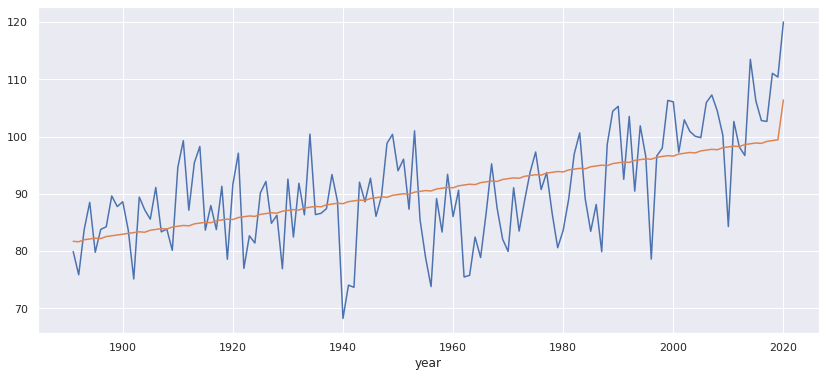

In [31]:
df_train.groupby('year')['tg'].mean().plot()
df_train.groupby('year')['trend_seasonal'].mean().plot()

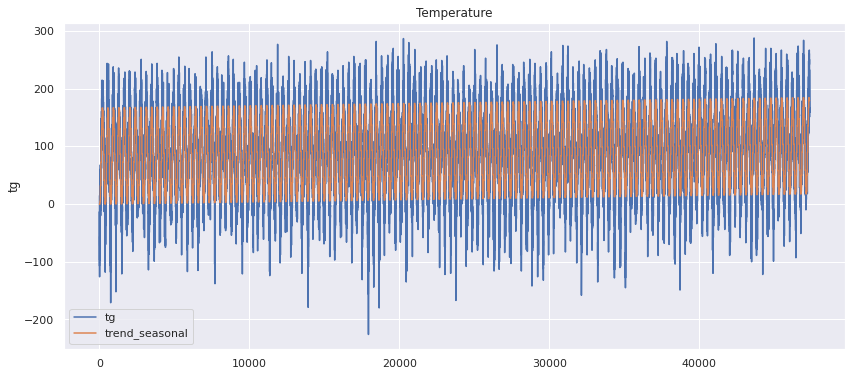

In [32]:
plot_temp(df=df_train[['tg', 'trend_seasonal']], ylim=False)

## 4. Calculating, plotting and storing the remainder

### 4.1 Calculating the remainder

In [33]:
df_train['remainder'] = df_train['tg'] - df_train['trend_seasonal']

In [34]:
df_train['remainder']

0       -106.833297
1        -75.833677
2       -102.834056
3        -12.834435
4        -40.834815
            ...    
47355    -20.608037
47356    -16.608417
47357    -15.608796
47358    -12.609175
47359    -20.609555
Name: remainder, Length: 47360, dtype: float64

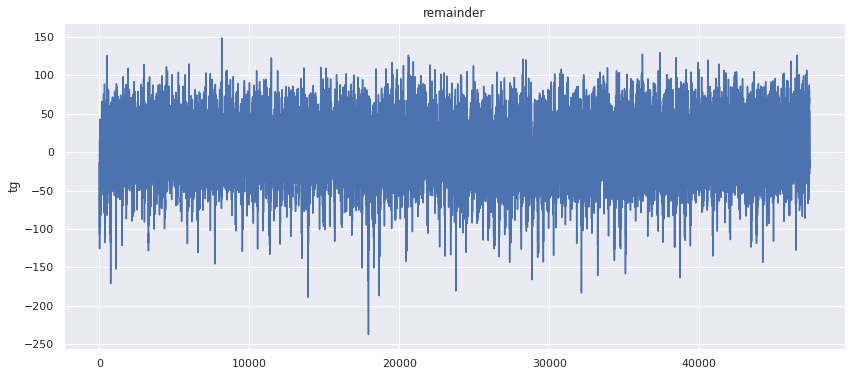

In [35]:
plot_temp(df_train['remainder'],title = "remainder",ylim=False)

In [36]:
df_train['remainder'].mean(), df_train['remainder'].std()

(-7.317269913110559e-15, 36.493968196887586)

### 4.2 Comparing the result with random-generated noise

In [37]:
np.random.seed(42)
df_train['randomness'] = np.random.normal(loc=0,scale=12,size = len(df_train))

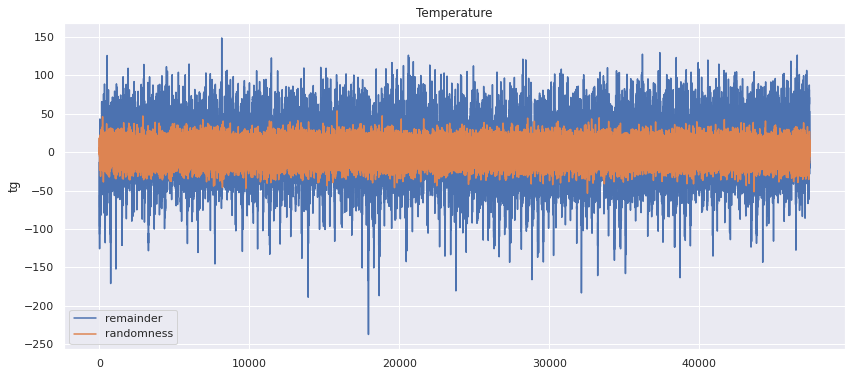

In [38]:
plot_temp(df_train[['remainder','randomness']],ylim =False)

In [39]:
df_train['remainder'].to_csv('~/Documents/spiced_work/own_code/week7/remainder.csv')

### 4.3 Using the remainder to evaluate the lag

In [40]:
df_remain = pd.read_csv('~/Documents/spiced_work/own_code/week7/remainder.csv', index_col=0, parse_dates=True)

In [41]:
df_remain

,remainder
0,-106.833297
1,-75.833677
2,-102.834056
3,-12.834435
4,-40.834815
...,...
47355,-20.608037
47356,-16.608417
47357,-15.608796
47358,-12.609175


In [42]:
# Plot the data
def plot_remainder(df, 
                   title='Remaining tenperature after modelling trend and seasonality'):
    '''
    Custom plotting function for plotting the flights dataset by Spiced Academy
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('temperature')
    plt.show()

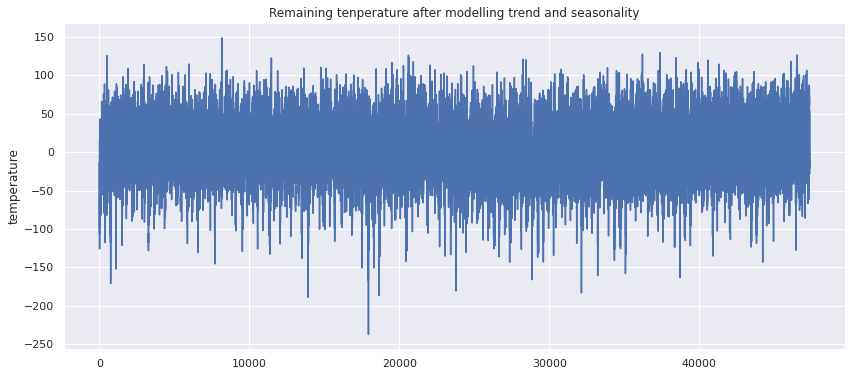

In [43]:
plot_remainder(df_remain['remainder'])

### 4.4 Adding one lag and fitting the model

In [44]:
df_remain['lag1'] = df_remain['remainder'].shift(1)
df_remain.head()

,remainder,lag1
0,-106.833297,NaN
1,-75.833677,-106.833297
2,-102.834056,-75.833677
3,-12.834435,-102.834056
4,-40.834815,-12.834435


In [45]:
df_remain.corr()

,remainder,lag1
remainder,1.000000,0.799944
lag1,0.799944,1.000000


<AxesSubplot:xlabel='lag1', ylabel='remainder'>

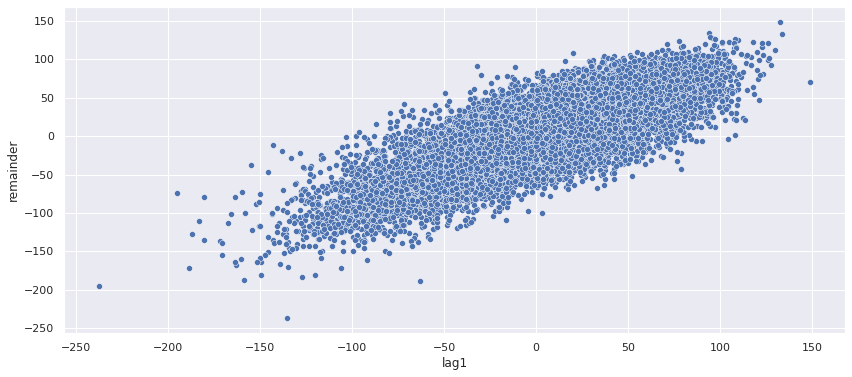

In [46]:
sns.scatterplot(x='lag1', y='remainder', data=df_remain)
# plt.show()

In [47]:
# Drop missing values
df_remain.dropna(inplace=True)
df_remain.head()

,remainder,lag1
1,-75.833677,-106.833297
2,-102.834056,-75.833677
3,-12.834435,-102.834056
4,-40.834815,-12.834435
5,-52.835194,-40.834815


In [48]:
# Assign X and y
X_rem = df_remain[['lag1']]
y_rem = df_remain['remainder']

In [49]:
# Create and fit the model
lrm = LinearRegression()
lrm.fit(X_rem, y_rem)

LinearRegression()

#### 4.4.1 Remainder-score

In [59]:
#calculating the score == accuracy score
np.round(lrm.score(X_rem,y_rem),6)

0.63991

### 4.5 Creating new predicitions

In [60]:
# Create predictions
df_remain['predictions_ar1'] = lrm.predict(X_rem)
df_remain.head()

,remainder,lag1,predictions_ar1,lag2
1,-75.833677,-106.833297,-85.451262,NaN
2,-102.834056,-75.833677,-60.655473,NaN
3,-12.834435,-102.834056,-82.252373,-75.833677
4,-40.834815,-12.834435,-10.264022,-102.834056
5,-52.835194,-40.834815,-32.660796,-12.834435


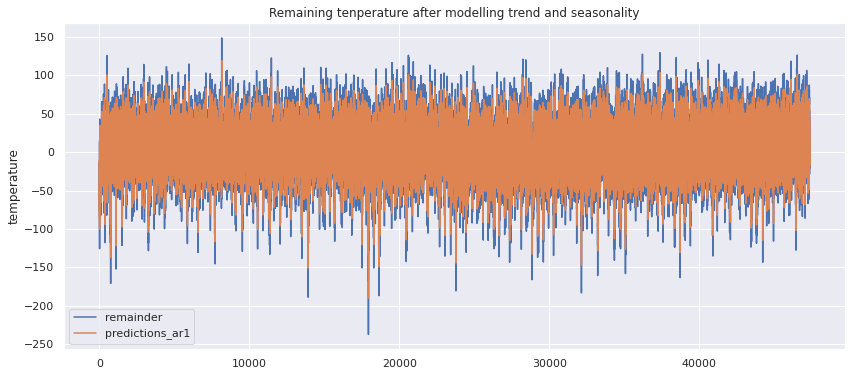

In [61]:
# Plot the original remainder and the prediction
plot_remainder(df_remain[['remainder', 'predictions_ar1']])

### 4.6 Adding a second lag and plotting the correlations

In [62]:
df_remain['lag2'] = df_remain['remainder'].shift(2)
df_remain.head()

,remainder,lag1,predictions_ar1,lag2
1,-75.833677,-106.833297,-85.451262,NaN
2,-102.834056,-75.833677,-60.655473,NaN
3,-12.834435,-102.834056,-82.252373,-75.833677
4,-40.834815,-12.834435,-10.264022,-102.834056
5,-52.835194,-40.834815,-32.660796,-12.834435


<AxesSubplot:xlabel='lag2', ylabel='remainder'>

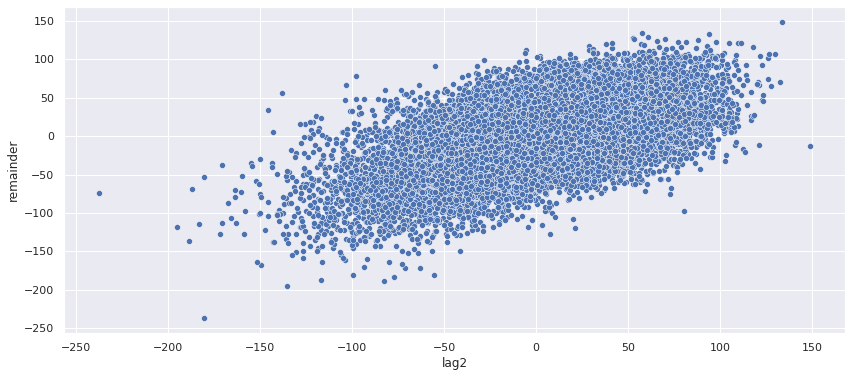

In [63]:
sns.scatterplot(x='lag2', y='remainder', data=df_remain)

In [64]:
round(df_remain[['remainder', 'lag1', 'lag2']].corr(), 2)

,remainder,lag1,lag2
remainder,1.0,0.8,0.6
lag1,0.8,1.0,0.8
lag2,0.6,0.8,1.0


In [78]:
df_remain.dropna(inplace=True)
df_remain.head()

,remainder,lag1,predictions_ar1,lag2,lag3,lag4,lag5,lag6
7,-111.835953,-55.835573,-44.659512,-52.835194,-40.834815,-12.834435,-102.834056,-75.833677
8,-108.836332,-111.835953,-89.452755,-55.835573,-52.835194,-40.834815,-12.834435,-102.834056
9,-125.836712,-108.836332,-87.053437,-111.835953,-55.835573,-52.835194,-40.834815,-12.834435
10,-86.837091,-125.836712,-100.651597,-108.836332,-111.835953,-55.835573,-52.835194,-40.834815
11,15.162530,-86.837091,-69.456818,-125.836712,-108.836332,-111.835953,-55.835573,-52.835194


In [79]:
X_rem2 = df_remain[['lag2']]
y_rem2 = df_remain['remainder']

In [80]:
lrm2 = LinearRegression()
lrm2.fit(X_rem2, y_rem2)

LinearRegression()

In [81]:
np.round(lrm.score(X_rem2,y_rem2),6)

0.319162

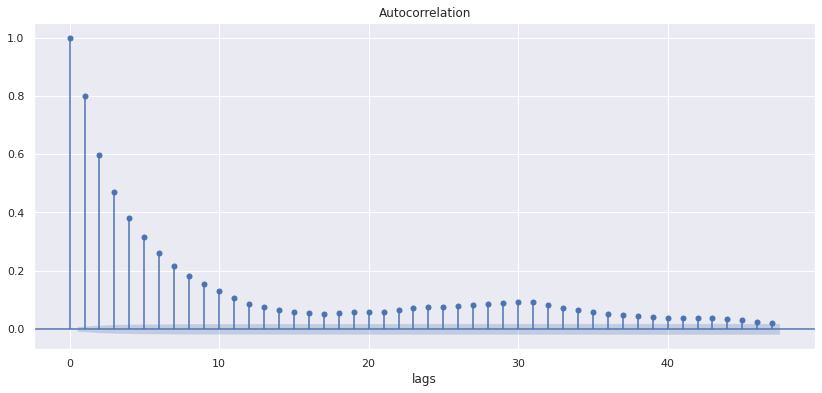

In [82]:
#Plotting an autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_remain['remainder'])
plt.xlabel('lags');

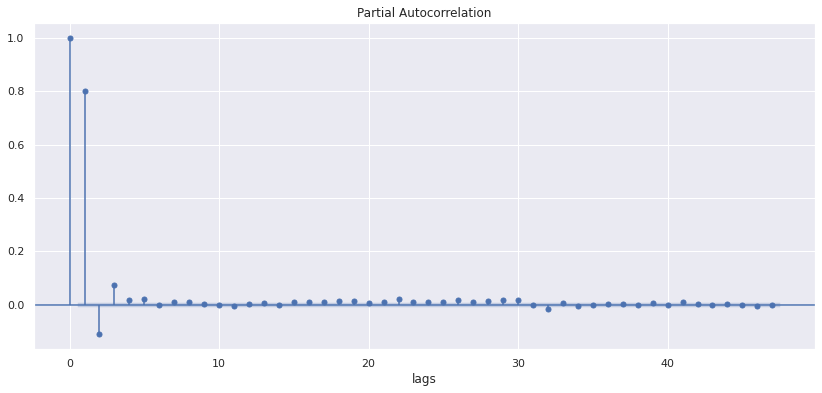

In [83]:
# Plotting of a partial autocorrelation
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_remain['remainder'])
plt.xlabel('lags');

In [84]:
selected_order = ar_select_order(df_remain['remainder'], maxlag = 12)

/home/nisaba/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nisaba/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/home/nisaba/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nisaba/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old nam

In [85]:
selected_order.ar_lags

array([1, 2, 3, 4, 5])

#### Autoregression

In [86]:
# Only use this if you feel comfortable
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(endog=df_remain['remainder'], lags=6).fit()

/home/nisaba/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/nisaba/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [87]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                47353
Model:                     AutoReg(6)   Log Likelihood             -212846.585
Method:               Conditional MLE   S.D. of innovations             21.683
Date:                Mon, 11 Oct 2021   AIC                              6.153
Time:                        08:50:41   BIC                              6.155
Sample:                             6   HQIC                             6.154
                                47353                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0034      0.100      0.034      0.973      -0.192       0.199
remainder.L1     0.8965      0.005    195.082      0.000       0.888       0.906
remainder.L2    -0.1770      0.006    -28.682      0.000      -0.189      -0.165
remainder.L3     0.0630      0.006     10.126      0.000       0.051       0.075
remainder.L4  4.665e-05      0.006      0.007      0.994      -0.012       0.012
remainder.L5     0.0189      0.006      3.056      0.002       0.007       0.031
remainder.L6    -0.0001      0.005     -0.023      0.982      -0.009       0.009
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2247           -0.0000j            1.2247           -0.0000
AR.2            1.2122           -1.8594j            2.2196           -0.1581
AR.3            1.2122           +1.8594j            2.2196            0.1581
AR.4           -1.8350           -2.3279j            2.9642           -0.3562
AR.5           -1.8350           +2.3279j            2.9642            0.3562
AR.6          178.0596           -0.0000j          178.0596           -0.0000
-----------------------------------------------------------------------------
"""

### 4.7 Adding more lags

In [88]:
df_remain['lag3'] = df_remain['remainder'].shift(3)
df_remain['lag4'] = df_remain['remainder'].shift(4)
df_remain['lag5'] = df_remain['remainder'].shift(5)
df_remain['lag6'] = df_remain['remainder'].shift(6)
df_remain.head(10)

,remainder,lag1,predictions_ar1,lag2,lag3,lag4,lag5,lag6
7,-111.835953,-55.835573,-44.659512,-52.835194,NaN,NaN,NaN,NaN
8,-108.836332,-111.835953,-89.452755,-55.835573,NaN,NaN,NaN,NaN
9,-125.836712,-108.836332,-87.053437,-111.835953,NaN,NaN,NaN,NaN
10,-86.837091,-125.836712,-100.651597,-108.836332,-111.835953,NaN,NaN,NaN
11,15.162530,-86.837091,-69.456818,-125.836712,-108.836332,-111.835953,NaN,NaN
12,5.162150,15.162530,12.130020,-86.837091,-125.836712,-108.836332,-111.835953,NaN
13,6.161771,5.162150,4.130977,15.162530,-86.837091,-125.836712,-108.836332,-111.835953
14,-50.838609,6.161771,4.930548,5.162150,15.162530,-86.837091,-125.836712,-108.836332
15,-96.838988,-50.838609,-40.662570,6.161771,5.162150,15.162530,-86.837091,-125.836712
16,-81.839367,-96.838988,-77.457074,-50.838609,6.161771,5.162150,15.162530,-86.837091


In [89]:
# Droping the missing values
df_remain.dropna(inplace=True)
df_remain.head()

,remainder,lag1,predictions_ar1,lag2,lag3,lag4,lag5,lag6
13,6.161771,5.162150,4.130977,15.162530,-86.837091,-125.836712,-108.836332,-111.835953
14,-50.838609,6.161771,4.930548,5.162150,15.162530,-86.837091,-125.836712,-108.836332
15,-96.838988,-50.838609,-40.662570,6.161771,5.162150,15.162530,-86.837091,-125.836712
16,-81.839367,-96.838988,-77.457074,-50.838609,6.161771,5.162150,15.162530,-86.837091
17,-55.839747,-81.839367,-65.459269,-96.838988,-50.838609,6.161771,5.162150,15.162530


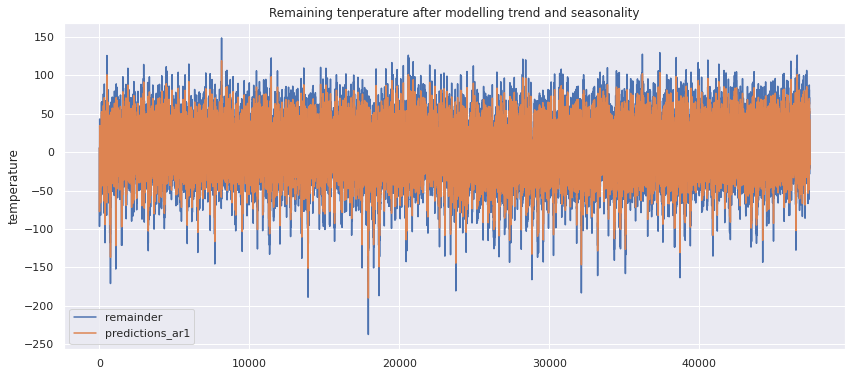

In [90]:
plot_remainder(df_remain[['remainder', 'predictions_ar1']])

In [91]:
round(df_remain[['remainder', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6']].corr(), 2)

,remainder,lag1,lag2,lag3,lag4,lag5,lag6
remainder,1.00,0.80,0.60,0.47,0.38,0.31,0.26
lag1,0.80,1.00,0.80,0.60,0.47,0.38,0.31
lag2,0.60,0.80,1.00,0.80,0.60,0.47,0.38
lag3,0.47,0.60,0.80,1.00,0.80,0.60,0.47
lag4,0.38,0.47,0.60,0.80,1.00,0.80,0.60
lag5,0.31,0.38,0.47,0.60,0.80,1.00,0.80
lag6,0.26,0.31,0.38,0.47,0.60,0.80,1.00


### 4.8 Adding the remainder to the original model and reevaluation

In [92]:
df_train['lag1'] = df_remain['lag1']
df_train['lag2'] = df_remain['lag2']
df_train['lag3'] = df_remain['lag3']
df_train['lag4'] = df_remain['lag4']
df_train['lag5'] = df_remain['lag5']
df_train['lag6'] = df_remain['lag6']

In [93]:
df_train.columns

Index(['date', 'tg', 'year', 'month', 'day', 'timestep', 'trend', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'trend_seasonal',
       'remainder', 'randomness', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5',
       'lag6'],
      dtype='object')

In [94]:
df_train.dropna(inplace=True)
df_train.head(20)

,date,tg,year,month,day,timestep,trend,month_2,month_3,month_4,...,month_12,trend_seasonal,remainder,randomness,lag1,lag2,lag3,lag4,lag5,lag6
13,1891-01-14,6,1891,1,14,13,81.340605,0,0,0,...,0,-0.161771,6.161771,-22.959363,5.162150,15.162530,-86.837091,-125.836712,-108.836332,-111.835953
14,1891-01-15,-51,1891,1,15,14,81.340997,0,0,0,...,0,-0.161391,-50.838609,-20.699014,6.161771,5.162150,15.162530,-86.837091,-125.836712,-108.836332
15,1891-01-16,-97,1891,1,16,15,81.341389,0,0,0,...,0,-0.161012,-96.838988,-6.747450,-50.838609,6.161771,5.162150,15.162530,-86.837091,-125.836712
16,1891-01-17,-82,1891,1,17,16,81.341782,0,0,0,...,0,-0.160633,-81.839367,-12.153973,-96.838988,-50.838609,6.161771,5.162150,15.162530,-86.837091
17,1891-01-18,-56,1891,1,18,17,81.342174,0,0,0,...,0,-0.160253,-55.839747,3.770968,-81.839367,-96.838988,-50.838609,6.161771,5.162150,15.162530
18,1891-01-19,-72,1891,1,19,18,81.342566,0,0,0,...,0,-0.159874,-71.840126,-10.896289,-55.839747,-81.839367,-96.838988,-50.838609,6.161771,5.162150
19,1891-01-20,-37,1891,1,20,19,81.342959,0,0,0,...,0,-0.159495,-36.840505,-16.947644,-71.840126,-55.839747,-81.839367,-96.838988,-50.838609,6.161771
20,1891-01-21,-24,1891,1,21,20,81.343351,0,0,0,...,0,-0.159115,-23.840885,17.587785,-36.840505,-71.840126,-55.839747,-81.839367,-96.838988,-50.838609
21,1891-01-22,-55,1891,1,22,21,81.343743,0,0,0,...,0,-0.158736,-54.841264,-2.709316,-23.840885,-36.840505,-71.840126,-55.839747,-81.839367,-96.838988
22,1891-01-23,-28,1891,1,23,22,81.344136,0,0,0,...,0,-0.158356,-27.841644,0.810338,-54.841264,-23.840885,-36.840505,-71.840126,-55.839747,-81.839367


In [95]:
# Define X and y drop unnecessary columns
X_train_full = df_train.drop(['date', 'tg', 'year', 'month', 'day', 'trend', 'trend_seasonal',
       'remainder', 'randomness'], axis=1)
y_train_full = df_train['tg']

# Instantiatimng the linear regression 
lrf = LinearRegression()

# Fitting the model 
lrf.fit(X_train_full,y_train_full)

LinearRegression()

In [96]:
X_train_full

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5,lag6
13,13,0,0,0,0,0,0,0,0,0,0,0,5.162150,15.162530,-86.837091,-125.836712,-108.836332,-111.835953
14,14,0,0,0,0,0,0,0,0,0,0,0,6.161771,5.162150,15.162530,-86.837091,-125.836712,-108.836332
15,15,0,0,0,0,0,0,0,0,0,0,0,-50.838609,6.161771,5.162150,15.162530,-86.837091,-125.836712
16,16,0,0,0,0,0,0,0,0,0,0,0,-96.838988,-50.838609,6.161771,5.162150,15.162530,-86.837091
17,17,0,0,0,0,0,0,0,0,0,0,0,-81.839367,-96.838988,-50.838609,6.161771,5.162150,15.162530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47355,47355,0,0,0,0,0,0,1,0,0,0,0,-14.607658,-22.607279,-28.606899,-6.606520,21.393860,50.394239
47356,47356,0,0,0,0,0,0,1,0,0,0,0,-20.608037,-14.607658,-22.607279,-28.606899,-6.606520,21.393860
47357,47357,0,0,0,0,0,0,1,0,0,0,0,-16.608417,-20.608037,-14.607658,-22.607279,-28.606899,-6.606520
47358,47358,0,0,0,0,0,0,1,0,0,0,0,-15.608796,-16.608417,-20.608037,-14.607658,-22.607279,-28.606899


#### 4.8.1 Lags-score

In [97]:
np.round(lrf.score(X_train_full,y_train_full), 3)

0.905

In [98]:
# Create a new predictions column
df_train['predictions_full_model'] = lrf.predict(X_train_full)

In [99]:
#df_train

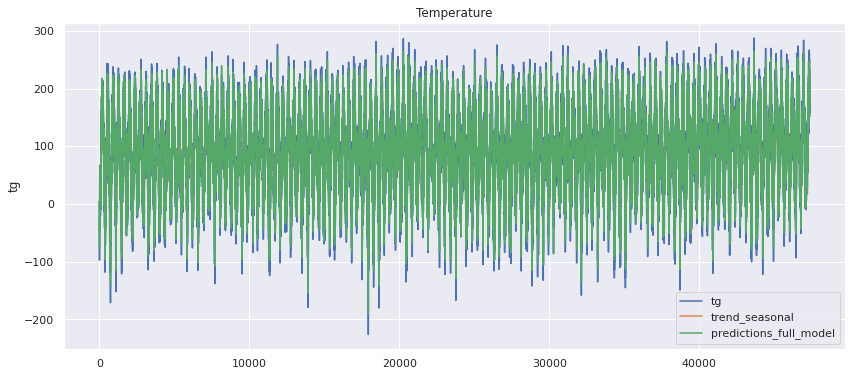

In [100]:
plot_temp(df_train[['tg', 'trend_seasonal', 'predictions_full_model']], ylim=False)

<AxesSubplot:xlabel='date'>

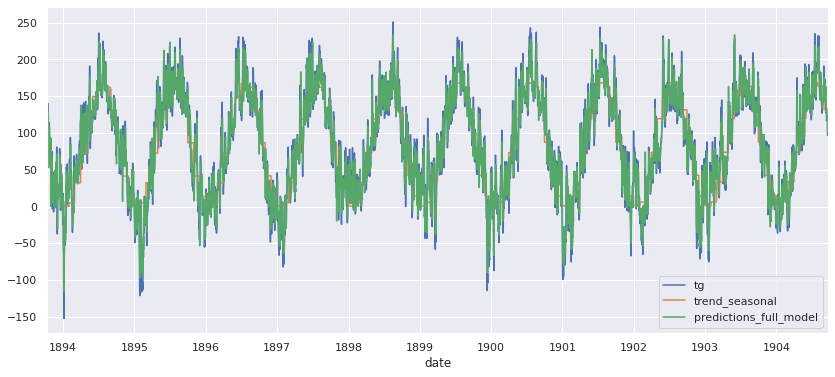

In [101]:
df_train.iloc[1000:5000].plot(x= 'date', y=['tg', 'trend_seasonal', 'predictions_full_model'])

<AxesSubplot:xlabel='date'>

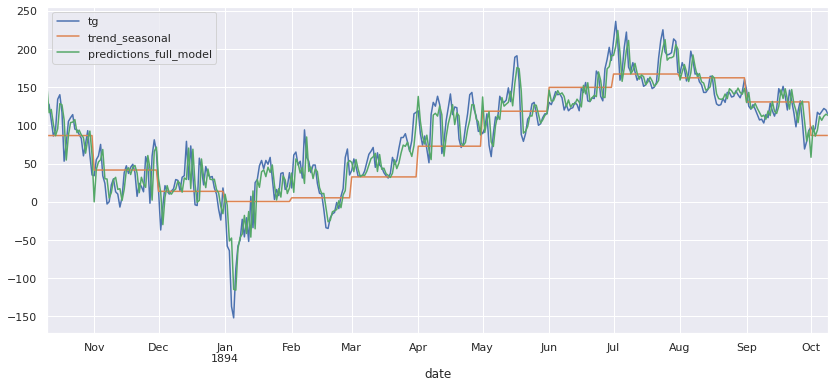

In [102]:
df_train.iloc[1000:1365].plot(x= 'date', y=['tg', 'trend_seasonal', 'predictions_full_model'])

<AxesSubplot:xlabel='date'>

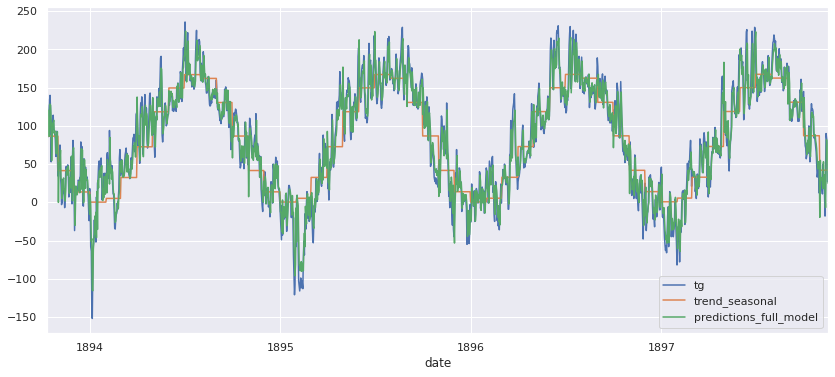

In [103]:
df_train.iloc[1000:2500].plot(x= 'date', y=['tg', 'trend_seasonal', 'predictions_full_model'])

<AxesSubplot:xlabel='date'>

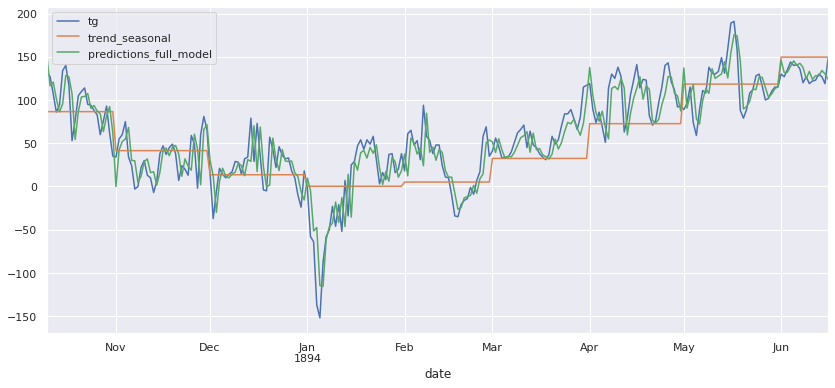

In [104]:
df_train.iloc[1000:1250].plot(x= 'date', y=['tg', 'trend_seasonal', 'predictions_full_model'])

<AxesSubplot:xlabel='date'>

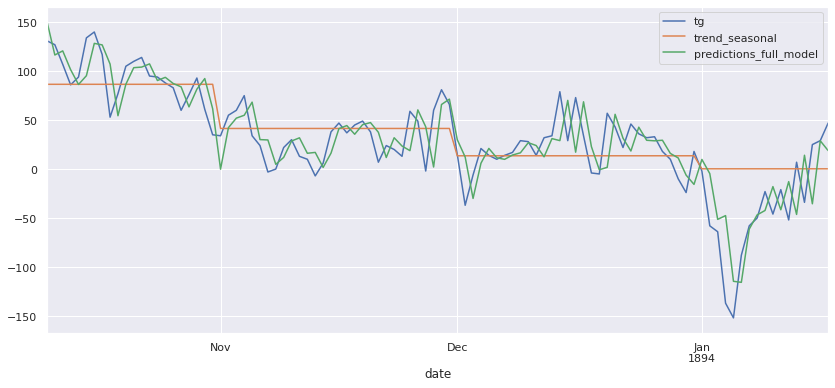

In [105]:
df_train.iloc[1000:1100].plot(x= 'date', y=['tg', 'trend_seasonal', 'predictions_full_model'])

<AxesSubplot:xlabel='date'>

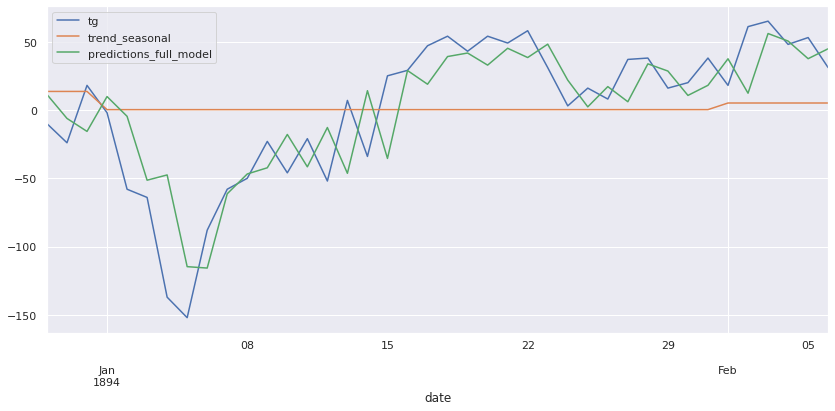

In [106]:
df_train.iloc[1080:1120].plot(x= 'date', y=['tg', 'trend_seasonal', 'predictions_full_model'])

In [107]:
df_train.head()

,date,tg,year,month,day,timestep,trend,month_2,month_3,month_4,...,trend_seasonal,remainder,randomness,lag1,lag2,lag3,lag4,lag5,lag6,predictions_full_model
13,1891-01-14,6,1891,1,14,13,81.340605,0,0,0,...,-0.161771,6.161771,-22.959363,5.162150,15.162530,-86.837091,-125.836712,-108.836332,-111.835953,-5.414662
14,1891-01-15,-51,1891,1,15,14,81.340997,0,0,0,...,-0.161391,-50.838609,-20.699014,6.161771,5.162150,15.162530,-86.837091,-125.836712,-108.836332,3.365055
15,1891-01-16,-97,1891,1,16,15,81.341389,0,0,0,...,-0.161012,-96.838988,-6.747450,-50.838609,6.161771,5.162150,15.162530,-86.837091,-125.836712,-47.798087
16,1891-01-17,-82,1891,1,17,16,81.341782,0,0,0,...,-0.160633,-81.839367,-12.153973,-96.838988,-50.838609,6.161771,5.162150,15.162530,-86.837091,-76.957804
17,1891-01-18,-56,1891,1,18,17,81.342174,0,0,0,...,-0.160253,-55.839747,3.770968,-81.839367,-96.838988,-50.838609,6.161771,5.162150,15.162530,-59.140221


<AxesSubplot:xlabel='date'>

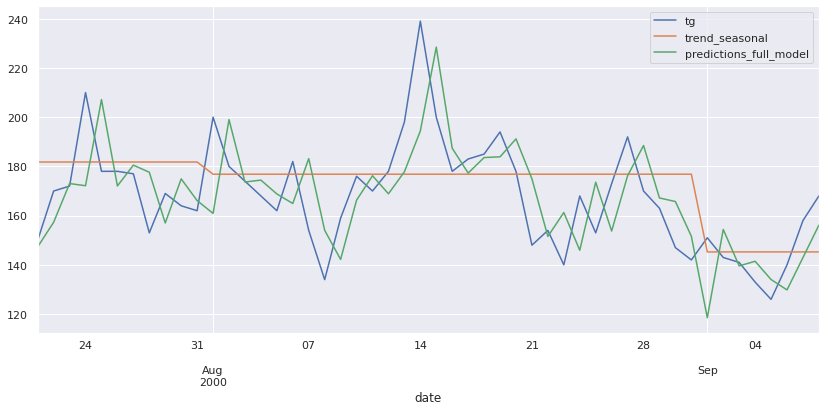

In [108]:
df_train.iloc[40000:40050].plot(x= 'date', y=['tg', 'trend_seasonal', 'predictions_full_model'])

#### 4.8.1 Correlations

In [109]:
pd.DataFrame(lrf.coef_.reshape(1,18), columns=X_train_full.columns)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5,lag6
0,0.000379,4.830123,32.058112,72.058347,117.786658,148.617952,166.325829,161.050633,129.724056,85.872531,41.104144,13.084398,0.896461,-0.176966,0.063042,0.000088,0.018859,0.000118


## 5. Evaluation of the model

In [110]:
# Creating a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [111]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_train_full, y_train_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [   0    1    2 ... 7889 7890 7891]
The validation data for the 1th iteration are the observations steps
    [ 7892  7893  7894 ... 15780 15781 15782]


The training data for the 2th iteration are the observations steps 
    [    0     1     2 ... 15780 15781 15782]
The validation data for the 2th iteration are the observations steps
    [15783 15784 15785 ... 23671 23672 23673]


The training data for the 3th iteration are the observations steps 
    [    0     1     2 ... 23671 23672 23673]
The validation data for the 3th iteration are the observations steps
    [23674 23675 23676 ... 31562 31563 31564]


The training data for the 4th iteration are the observations steps 
    [    0     1     2 ... 31562 31563 31564]
The validation data for the 4th iteration are the observations steps
    [31565 31566 31567 ... 39453 39454 39455]


The training data for the 5th iteration are the observations steps 
    [    0    

In [112]:
# Create the time series split
time_series_split = ts_split.split(X_train_full, y_train_full) 

In [113]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=lrf, 
                         X=X_train_full, y=y_train_full,
                         cv=time_series_split)
result

array([0.91185945, 0.90751796, 0.8946721 , 0.89264224, 0.90325565])

In [114]:
result.mean()

0.9019894795166303

## 6. Prepapring the test-data and testing the model

In [115]:
df_test = df[-365:]

In [116]:
df_test

,date,tg,year,month,day
47360,2020-09-01,153,2020,9,1
47361,2020-09-02,148,2020,9,2
47362,2020-09-03,139,2020,9,3
47363,2020-09-04,175,2020,9,4
47364,2020-09-05,151,2020,9,5
...,...,...,...,...,...
47720,2021-08-27,151,2021,8,27
47721,2021-08-28,152,2021,8,28
47722,2021-08-29,158,2021,8,29
47723,2021-08-30,169,2021,8,30


In [117]:
# Get last timestep of the training data
last_train_timestep = df_train.loc[df_train.index[-5], 'timestep']

In [118]:
#df_train.tail()

In [119]:
# Create a timestep for the whole test data
df_test['timestep'] = list(range(last_train_timestep + 3, 
                            len(df_test) + last_train_timestep + 3))
df_test.head(10)

<ipython-input-119-80935cfcacb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['timestep'] = list(range(last_train_timestep + 3,


,date,tg,year,month,day,timestep
47360,2020-09-01,153,2020,9,1,47358
47361,2020-09-02,148,2020,9,2,47359
47362,2020-09-03,139,2020,9,3,47360
47363,2020-09-04,175,2020,9,4,47361
47364,2020-09-05,151,2020,9,5,47362
47365,2020-09-06,136,2020,9,6,47363
47366,2020-09-07,152,2020,9,7,47364
47367,2020-09-08,168,2020,9,8,47365
47368,2020-09-09,175,2020,9,9,47366
47369,2020-09-10,144,2020,9,10,47367


In [120]:
seasonal_dummies = pd.get_dummies(df_test['month'],prefix='month',drop_first=True)

df_test = df_test.join(seasonal_dummies)
df_test

,date,tg,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
47360,2020-09-01,153,2020,9,1,47358,0,0,0,0,0,0,0,1,0,0,0
47361,2020-09-02,148,2020,9,2,47359,0,0,0,0,0,0,0,1,0,0,0
47362,2020-09-03,139,2020,9,3,47360,0,0,0,0,0,0,0,1,0,0,0
47363,2020-09-04,175,2020,9,4,47361,0,0,0,0,0,0,0,1,0,0,0
47364,2020-09-05,151,2020,9,5,47362,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47720,2021-08-27,151,2021,8,27,47718,0,0,0,0,0,0,1,0,0,0,0
47721,2021-08-28,152,2021,8,28,47719,0,0,0,0,0,0,1,0,0,0,0
47722,2021-08-29,158,2021,8,29,47720,0,0,0,0,0,0,1,0,0,0,0
47723,2021-08-30,169,2021,8,30,47721,0,0,0,0,0,0,1,0,0,0,0


In [121]:
df_test.columns

Index(['date', 'tg', 'year', 'month', 'day', 'timestep', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

In [122]:
X_test = df_test.drop(columns=['date', 'tg', 'year', 'month', 'day'])

In [123]:
X_test

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
47360,47358,0,0,0,0,0,0,0,1,0,0,0
47361,47359,0,0,0,0,0,0,0,1,0,0,0
47362,47360,0,0,0,0,0,0,0,1,0,0,0
47363,47361,0,0,0,0,0,0,0,1,0,0,0
47364,47362,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
47720,47718,0,0,0,0,0,0,1,0,0,0,0
47721,47719,0,0,0,0,0,0,1,0,0,0,0
47722,47720,0,0,0,0,0,0,1,0,0,0,0
47723,47721,0,0,0,0,0,0,1,0,0,0,0


In [124]:
df_test['trend_seasonal'] = lr_ohe.predict(X_test)
df_test.head()

,date,tg,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
47360,2020-09-01,153,2020,9,1,47358,0,0,0,0,0,0,0,1,0,0,0,148.033960
47361,2020-09-02,148,2020,9,2,47359,0,0,0,0,0,0,0,1,0,0,0,148.034339
47362,2020-09-03,139,2020,9,3,47360,0,0,0,0,0,0,0,1,0,0,0,148.034719
47363,2020-09-04,175,2020,9,4,47361,0,0,0,0,0,0,0,1,0,0,0,148.035098
47364,2020-09-05,151,2020,9,5,47362,0,0,0,0,0,0,0,1,0,0,0,148.035478


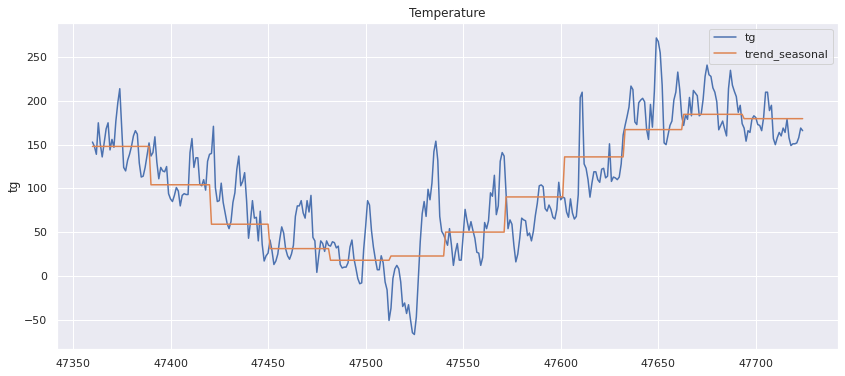

In [125]:
plot_temp(df_test[['tg', 'trend_seasonal']], ylim=False)

In [126]:
df_test['remainder'] = df_test['tg'] - df_test['trend_seasonal']

In [127]:
df_test

,date,tg,year,month,day,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
47360,2020-09-01,153,2020,9,1,47358,0,0,0,0,0,0,0,1,0,0,0,148.033960,4.966040
47361,2020-09-02,148,2020,9,2,47359,0,0,0,0,0,0,0,1,0,0,0,148.034339,-0.034339
47362,2020-09-03,139,2020,9,3,47360,0,0,0,0,0,0,0,1,0,0,0,148.034719,-9.034719
47363,2020-09-04,175,2020,9,4,47361,0,0,0,0,0,0,0,1,0,0,0,148.035098,26.964902
47364,2020-09-05,151,2020,9,5,47362,0,0,0,0,0,0,0,1,0,0,0,148.035478,2.964522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47720,2021-08-27,151,2021,8,27,47718,0,0,0,0,0,0,1,0,0,0,0,179.745753,-28.745753
47721,2021-08-28,152,2021,8,28,47719,0,0,0,0,0,0,1,0,0,0,0,179.746133,-27.746133
47722,2021-08-29,158,2021,8,29,47720,0,0,0,0,0,0,1,0,0,0,0,179.746512,-21.746512
47723,2021-08-30,169,2021,8,30,47721,0,0,0,0,0,0,1,0,0,0,0,179.746892,-10.746892


In [128]:
# Create the lagged variable
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)
df_test['lag4'] = df_test['remainder'].shift(4)
df_test['lag5'] = df_test['remainder'].shift(5)
df_test['lag6'] = df_test['remainder'].shift(6)

In [129]:
df_test.isna().sum()

date              0
tg                0
year              0
month             0
day               0
timestep          0
month_2           0
month_3           0
month_4           0
month_5           0
month_6           0
month_7           0
month_8           0
month_9           0
month_10          0
month_11          0
month_12          0
trend_seasonal    0
remainder         0
lag1              1
lag2              2
lag3              3
lag4              4
lag5              5
lag6              6
dtype: int64

In [130]:
X_full_test = df_test.drop(columns=['tg', 'remainder', 'year', 'month', 'day', 'date'])

In [131]:
X_full_test.head(10)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,lag1,lag2,lag3,lag4,lag5,lag6
47360,47358,0,0,0,0,0,0,0,1,0,0,0,148.033960,NaN,NaN,NaN,NaN,NaN,NaN
47361,47359,0,0,0,0,0,0,0,1,0,0,0,148.034339,4.966040,NaN,NaN,NaN,NaN,NaN
47362,47360,0,0,0,0,0,0,0,1,0,0,0,148.034719,-0.034339,4.966040,NaN,NaN,NaN,NaN
47363,47361,0,0,0,0,0,0,0,1,0,0,0,148.035098,-9.034719,-0.034339,4.966040,NaN,NaN,NaN
47364,47362,0,0,0,0,0,0,0,1,0,0,0,148.035478,26.964902,-9.034719,-0.034339,4.966040,NaN,NaN
47365,47363,0,0,0,0,0,0,0,1,0,0,0,148.035857,2.964522,26.964902,-9.034719,-0.034339,4.966040,NaN
47366,47364,0,0,0,0,0,0,0,1,0,0,0,148.036236,-12.035857,2.964522,26.964902,-9.034719,-0.034339,4.966040
47367,47365,0,0,0,0,0,0,0,1,0,0,0,148.036616,3.963764,-12.035857,2.964522,26.964902,-9.034719,-0.034339
47368,47366,0,0,0,0,0,0,0,1,0,0,0,148.036995,19.963384,3.963764,-12.035857,2.964522,26.964902,-9.034719
47369,47367,0,0,0,0,0,0,0,1,0,0,0,148.037374,26.963005,19.963384,3.963764,-12.035857,2.964522,26.964902


### 6.1 Filling the Nans

In [132]:
X_full_test.loc[47360, 'lag1'] = df_train.loc[47329,'remainder']

X_full_test.loc[47360, 'lag2'] = df_train.loc[47329,'remainder']
X_full_test.loc[47361, 'lag2'] = df_train.loc[47330,'remainder']

X_full_test.loc[47360, 'lag3'] = df_train.loc[47329,'remainder']
X_full_test.loc[47361, 'lag3'] = df_train.loc[47330,'remainder']
X_full_test.loc[47362, 'lag3'] = df_train.loc[47331,'remainder']

X_full_test.loc[47360, 'lag4'] = df_train.loc[47329,'remainder']
X_full_test.loc[47361, 'lag4'] = df_train.loc[47330,'remainder']
X_full_test.loc[47362, 'lag4'] = df_train.loc[47331,'remainder']
X_full_test.loc[47363, 'lag4'] = df_train.loc[47332,'remainder']

X_full_test.loc[47360, 'lag5'] = df_train.loc[47329,'remainder']
X_full_test.loc[47361, 'lag5'] = df_train.loc[47330,'remainder']
X_full_test.loc[47362, 'lag5'] = df_train.loc[47331,'remainder']
X_full_test.loc[47363, 'lag5'] = df_train.loc[47332,'remainder']
X_full_test.loc[47364, 'lag5'] = df_train.loc[47333,'remainder']

X_full_test.loc[47360, 'lag6'] = df_train.loc[47329,'remainder']
X_full_test.loc[47361, 'lag6'] = df_train.loc[47330,'remainder']
X_full_test.loc[47362, 'lag6'] = df_train.loc[47331,'remainder']
X_full_test.loc[47363, 'lag6'] = df_train.loc[47332,'remainder']
X_full_test.loc[47364, 'lag6'] = df_train.loc[47333,'remainder']
X_full_test.loc[47365, 'lag6'] = df_train.loc[47334,'remainder']

In [133]:
X_full_test.head(15)

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,lag1,lag2,lag3,lag4,lag5,lag6
47360,47358,0,0,0,0,0,0,0,1,0,0,0,148.033960,39.401827,39.401827,39.401827,39.401827,39.401827,39.401827
47361,47359,0,0,0,0,0,0,0,1,0,0,0,148.034339,4.966040,8.401447,8.401447,8.401447,8.401447,8.401447
47362,47360,0,0,0,0,0,0,0,1,0,0,0,148.034719,-0.034339,4.966040,-13.598932,-13.598932,-13.598932,-13.598932
47363,47361,0,0,0,0,0,0,0,1,0,0,0,148.035098,-9.034719,-0.034339,4.966040,-17.599311,-17.599311,-17.599311
47364,47362,0,0,0,0,0,0,0,1,0,0,0,148.035478,26.964902,-9.034719,-0.034339,4.966040,40.400309,40.400309
47365,47363,0,0,0,0,0,0,0,1,0,0,0,148.035857,2.964522,26.964902,-9.034719,-0.034339,4.966040,69.399930
47366,47364,0,0,0,0,0,0,0,1,0,0,0,148.036236,-12.035857,2.964522,26.964902,-9.034719,-0.034339,4.966040
47367,47365,0,0,0,0,0,0,0,1,0,0,0,148.036616,3.963764,-12.035857,2.964522,26.964902,-9.034719,-0.034339
47368,47366,0,0,0,0,0,0,0,1,0,0,0,148.036995,19.963384,3.963764,-12.035857,2.964522,26.964902,-9.034719
47369,47367,0,0,0,0,0,0,0,1,0,0,0,148.037374,26.963005,19.963384,3.963764,-12.035857,2.964522,26.964902


In [159]:
# Create the predictions
df_test['predictions_full_model'] = lrf.predict(X_full_test)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 18 is different from 19)

In [135]:
plot_temp(df_test[['tg', 'trend_seasonal', 'predictions_full_model']], ylim=False)

KeyError: "['predictions_full_model'] not in index"

In [136]:
# Create the complete dataset and plot it
df_full = df_train[['tg', 'trend_seasonal', 'predictions_full_model']].append(df_test[['tg', 'trend_seasonal', 'predictions_full_model']])

KeyError: "['predictions_full_model'] not in index"

In [137]:
plot_temp(df_full, ylim=False)

NameError: name 'df_full' is not defined

In [138]:
df_full.iloc[1000:1050].plot(y=['tg', 'trend_seasonal', 'predictions_full_model'])

NameError: name 'df_full' is not defined

In [139]:
np.round(lrf.score(X_full_test,y_train), 3)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 18 is different from 19)

In [140]:
print(f"""
{lrf.score(X_full_test, df_test['tg'])}
{lr.score(X_test, df_full['tg'])}
""")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 18 is different from 19)

## 7. Predicting the future

### 7.1 Building the combined data

In [141]:
df_test

,date,tg,year,month,day,timestep,month_2,month_3,month_4,month_5,...,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,lag4,lag5,lag6
47360,2020-09-01,153,2020,9,1,47358,0,0,0,0,...,0,0,148.033960,4.966040,NaN,NaN,NaN,NaN,NaN,NaN
47361,2020-09-02,148,2020,9,2,47359,0,0,0,0,...,0,0,148.034339,-0.034339,4.966040,NaN,NaN,NaN,NaN,NaN
47362,2020-09-03,139,2020,9,3,47360,0,0,0,0,...,0,0,148.034719,-9.034719,-0.034339,4.966040,NaN,NaN,NaN,NaN
47363,2020-09-04,175,2020,9,4,47361,0,0,0,0,...,0,0,148.035098,26.964902,-9.034719,-0.034339,4.966040,NaN,NaN,NaN
47364,2020-09-05,151,2020,9,5,47362,0,0,0,0,...,0,0,148.035478,2.964522,26.964902,-9.034719,-0.034339,4.966040,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47720,2021-08-27,151,2021,8,27,47718,0,0,0,0,...,0,0,179.745753,-28.745753,-28.745374,-30.744995,-21.744615,-0.744236,-15.743856,-10.743477
47721,2021-08-28,152,2021,8,28,47719,0,0,0,0,...,0,0,179.746133,-27.746133,-28.745753,-28.745374,-30.744995,-21.744615,-0.744236,-15.743856
47722,2021-08-29,158,2021,8,29,47720,0,0,0,0,...,0,0,179.746512,-21.746512,-27.746133,-28.745753,-28.745374,-30.744995,-21.744615,-0.744236
47723,2021-08-30,169,2021,8,30,47721,0,0,0,0,...,0,0,179.746892,-10.746892,-21.746512,-27.746133,-28.745753,-28.745374,-30.744995,-21.744615


In [142]:
# Combine train and test data
df_combined = df_train.append(df_test)
df_combined.head()

,date,tg,year,month,day,timestep,trend,month_2,month_3,month_4,...,trend_seasonal,remainder,randomness,lag1,lag2,lag3,lag4,lag5,lag6,predictions_full_model
13,1891-01-14,6,1891,1,14,13,81.340605,0,0,0,...,-0.161771,6.161771,-22.959363,5.162150,15.162530,-86.837091,-125.836712,-108.836332,-111.835953,-5.414662
14,1891-01-15,-51,1891,1,15,14,81.340997,0,0,0,...,-0.161391,-50.838609,-20.699014,6.161771,5.162150,15.162530,-86.837091,-125.836712,-108.836332,3.365055
15,1891-01-16,-97,1891,1,16,15,81.341389,0,0,0,...,-0.161012,-96.838988,-6.747450,-50.838609,6.161771,5.162150,15.162530,-86.837091,-125.836712,-47.798087
16,1891-01-17,-82,1891,1,17,16,81.341782,0,0,0,...,-0.160633,-81.839367,-12.153973,-96.838988,-50.838609,6.161771,5.162150,15.162530,-86.837091,-76.957804
17,1891-01-18,-56,1891,1,18,17,81.342174,0,0,0,...,-0.160253,-55.839747,3.770968,-81.839367,-96.838988,-50.838609,6.161771,5.162150,15.162530,-59.140221


In [143]:
#df_combined.isna().sum()

In [144]:
# Re-train the model on the whole dataset
X_combined = df_combined.drop(columns=['date','tg', 'year', 'month', 'day', 'trend', 'remainder', 'randomness', 'trend_seasonal', 
                                       'predictions_full_model'])
y_combined = df_combined['tg']

In [145]:
#only needed: timestep ohe-months lags

In [146]:
X_combined.loc[47360, 'lag1'] = df_train.loc[47329,'remainder']

X_combined.loc[47360, 'lag2'] = df_train.loc[47329,'remainder']
X_combined.loc[47361, 'lag2'] = df_train.loc[47330,'remainder']

X_combined.loc[47360, 'lag3'] = df_train.loc[47329,'remainder']
X_combined.loc[47361, 'lag3'] = df_train.loc[47330,'remainder']
X_combined.loc[47362, 'lag3'] = df_train.loc[47331,'remainder']

X_combined.loc[47360, 'lag4'] = df_train.loc[47329,'remainder']
X_combined.loc[47361, 'lag4'] = df_train.loc[47330,'remainder']
X_combined.loc[47362, 'lag4'] = df_train.loc[47331,'remainder']
X_combined.loc[47363, 'lag4'] = df_train.loc[47332,'remainder']

X_combined.loc[47360, 'lag5'] = df_train.loc[47329,'remainder']
X_combined.loc[47361, 'lag5'] = df_train.loc[47330,'remainder']
X_combined.loc[47362, 'lag5'] = df_train.loc[47331,'remainder']
X_combined.loc[47363, 'lag5'] = df_train.loc[47332,'remainder']
X_combined.loc[47364, 'lag5'] = df_train.loc[47333,'remainder']

X_combined.loc[47360, 'lag6'] = df_train.loc[47329,'remainder']
X_combined.loc[47361, 'lag6'] = df_train.loc[47330,'remainder']
X_combined.loc[47362, 'lag6'] = df_train.loc[47331,'remainder']
X_combined.loc[47363, 'lag6'] = df_train.loc[47332,'remainder']
X_combined.loc[47364, 'lag6'] = df_train.loc[47333,'remainder']
X_combined.loc[47365, 'lag6'] = df_train.loc[47334,'remainder']

In [147]:
X_combined

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5,lag6
13,13,0,0,0,0,0,0,0,0,0,0,0,5.162150,15.162530,-86.837091,-125.836712,-108.836332,-111.835953
14,14,0,0,0,0,0,0,0,0,0,0,0,6.161771,5.162150,15.162530,-86.837091,-125.836712,-108.836332
15,15,0,0,0,0,0,0,0,0,0,0,0,-50.838609,6.161771,5.162150,15.162530,-86.837091,-125.836712
16,16,0,0,0,0,0,0,0,0,0,0,0,-96.838988,-50.838609,6.161771,5.162150,15.162530,-86.837091
17,17,0,0,0,0,0,0,0,0,0,0,0,-81.839367,-96.838988,-50.838609,6.161771,5.162150,15.162530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47720,47718,0,0,0,0,0,0,1,0,0,0,0,-28.745374,-30.744995,-21.744615,-0.744236,-15.743856,-10.743477
47721,47719,0,0,0,0,0,0,1,0,0,0,0,-28.745753,-28.745374,-30.744995,-21.744615,-0.744236,-15.743856
47722,47720,0,0,0,0,0,0,1,0,0,0,0,-27.746133,-28.745753,-28.745374,-30.744995,-21.744615,-0.744236
47723,47721,0,0,0,0,0,0,1,0,0,0,0,-21.746512,-27.746133,-28.745753,-28.745374,-30.744995,-21.744615


In [148]:
X_combined.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6'],
      dtype='object')

### 7.2 Instatiating and fitting a rl-model 

In [149]:
lr_combined = LinearRegression()
lr_combined.fit(X_combined, y_combined)

LinearRegression()

In [150]:
np.round(lr_combined.score(X_combined,y_combined), 3)

0.906

### 7.3 Creating the row for the predicted day

In [151]:
#Creating a new row for the predicted day
timestep = df_combined['timestep'].max() + 1
months = [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
#lag = df_combined.loc[47724, 'remainder']


In [152]:
X_future = [timestep]
X_future.extend(months)

In [153]:
X_future = pd.DataFrame([X_future])

In [154]:
X_future['lag3'] = df_combined.loc[47724, 'lag3']
X_future['lag4'] = df_combined.loc[47724, 'lag4']
X_future['lag5'] = df_combined.loc[47724, 'lag5']
X_future['lag6'] = df_combined.loc[47724, 'lag6']
X_future['lag1'] = df_combined.loc[47724, 'lag1']
X_future['lag2'] = df_combined.loc[47724, 'lag2']

In [155]:
#X_future

In [156]:
X_future.columns = X_combined.columns

X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3,lag4,lag5,lag6
0,47723,0,0,0,0,0,0,0,1,0,0,0,-27.746133,-28.745753,-28.745374,-30.744995,-10.746892,-21.746512


### 7.4 Prediction

In [157]:
tomorrow_temp = np.round(lr_combined.predict(X_future),2)
print('The temperature in Hamburg on the 1. of September 2021 will be:', tomorrow_temp/10, '°C')

The temperature in Hamburg on the 1. of September 2021 will be: [12.621] °C


In [158]:
# The average date on 1.9.2021 in Hamburg was 16/17°C, the dates used are from Seewarte